In [43]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats("svg")
import numpy as np
from sklearn.model_selection import train_test_split
from torchsummary import summary

In [44]:
n_per_cluster = 1_000
img_size = 91

x = np.linspace(-4, 4, img_size)
X, Y = np.meshgrid(x, x)

g_widths = np.linspace(2, 20, n_per_cluster)

images = torch.zeros(n_per_cluster, 1, img_size, img_size)
occ_images = torch.zeros(n_per_cluster, 1, img_size, img_size)

In [45]:
for i in range(n_per_cluster):
    random_offset = 2*np.random.randn(2)
    gaussian = np.exp(-((X-random_offset[0])**2 + (Y-random_offset[1])**2) / (2*g_widths[i]**2))
    # adding noise
    gaussian = gaussian + np.random.randn(img_size, img_size) / 5
    images[i,:,:,:] = torch.Tensor(gaussian).reshape(1, img_size, img_size)
    loc = np.random.choice(np.arange(2, 28))
    wid = np.random.choice(np.arange(2, 6))
    if np.random.randn()>0:
        gaussian[loc:loc+wid,:] = 1
    else:
        gaussian[:,loc:loc+wid] = 1
    occ_images[i,:,:,:] = torch.Tensor(gaussian).reshape(1, img_size, img_size)

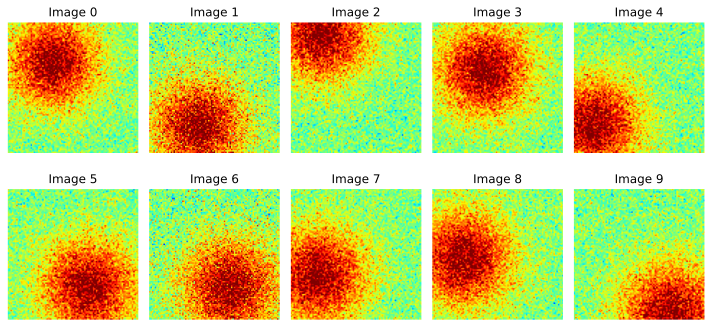

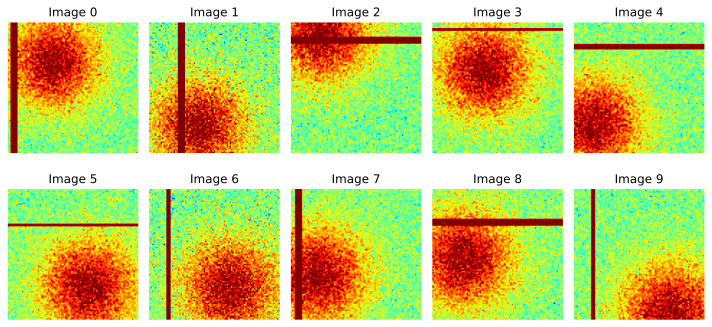

In [46]:
fig, axs = plt.subplots(2, 5, figsize=(10, 5))
for i, ax in enumerate(axs.flatten()):
    ax.imshow(images[i, :, :, :].view(img_size, img_size, 1), vmax=1, vmin=-1, cmap="jet")
    ax.set_title(f"Image {i}")
    ax.axis("off")
plt.tight_layout()
plt.show()

fig, axs = plt.subplots(2, 5, figsize=(10, 5))
for i, ax in enumerate(axs.flatten()):
    ax.imshow(occ_images[i, :, :, :].view(img_size, img_size, 1), vmax=1, vmin=-1, cmap="jet")
    ax.set_title(f"Image {i}")
    ax.axis("off")
plt.tight_layout()
plt.show()

In [47]:
class MyL1Loss(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
    def forward(self, y_pred, y):
        # x is model output
        # y is target
        return torch.mean(torch.abs(y_pred - y))

In [48]:
class MyL2AveLoss(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
    def forward(self, y_pred, y):
        l1 = torch.mean((y_pred-y)**2)
        l2 = torch.abs(torch.mean(y_pred))
        return l1 + l2

In [53]:
# Mike Says something fishy about this
class MyCorrLoss(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
    def forward(self, y_pred, y):
        y_pred_mean = torch.mean(y_pred)
        y_mean = torch.mean(y)
        l1 = torch.sum((y_pred - y_pred_mean)*(y - y_mean))
        return -l1/((y.shape[0] - 1)*torch.std(y_pred)*torch.std(y))

In [50]:
def create_model(lf):
    class GauseAE(nn.Module):
        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            self.enc = nn.Sequential(
                nn.Conv2d(1, 6, 3, 1, 1), # (91 + 2*1 - 3)/1 + 1
                nn.ReLU(),
                nn.MaxPool2d(2), # 91 // 2 = 45
                nn.Conv2d(6, 4, 3, 1, 1), # (45 + 2*1 - 3)/1 + 1
                nn.ReLU(),
                nn.MaxPool2d(2), # 45 // 2 = 2
            )
            self.dec = nn.Sequential(
                nn.ConvTranspose2d(4, 6, 3, 2),
                nn.ReLU(),
                nn.ConvTranspose2d(6, 1, 3, 2)
            )
        def forward(self, x):
            return self.dec(self.enc(x))
    net = GauseAE()
    lossfunc = lf()
    optimizer = torch.optim.Adam(net.parameters(), lr=.01)
    return net, lossfunc, optimizer

In [51]:
def train_model(lf):
    net, lossfunc, optimizer = create_model(lf)
    epochs = 50
    batch_size = 16
    losses = []
    for ei in range(epochs):
        batch_loss = []
        net.train()
        for i in range(images.shape[0]//batch_size):
            x = images[i*batch_size:(i+1)*batch_size]
            y = net(x)
            loss = lossfunc(y, x)
            batch_loss.append(loss.detach().item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        losses.append(np.mean(batch_loss).item())
    return losses, net

In [54]:
lfs = [MyL1Loss, MyL2AveLoss, MyCorrLoss]
results = np.zeros((len(lfs), 50))
models = [None] * len(lfs)
for i, lf in enumerate(lfs):
    print(f"Processing {lf().__class__.__name__}")
    losses, net = train_model(lf)
    results[i,:] = losses
    models[i] = net

Processing MyL1Loss
Processing MyL2AveLoss
Processing MyCorrLoss


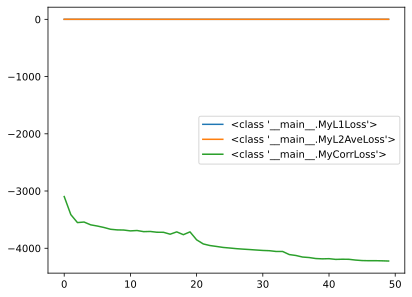

In [56]:
for i, lf in enumerate(lfs):
    plt.plot(results[i,:])
plt.legend(lfs)
plt.show()

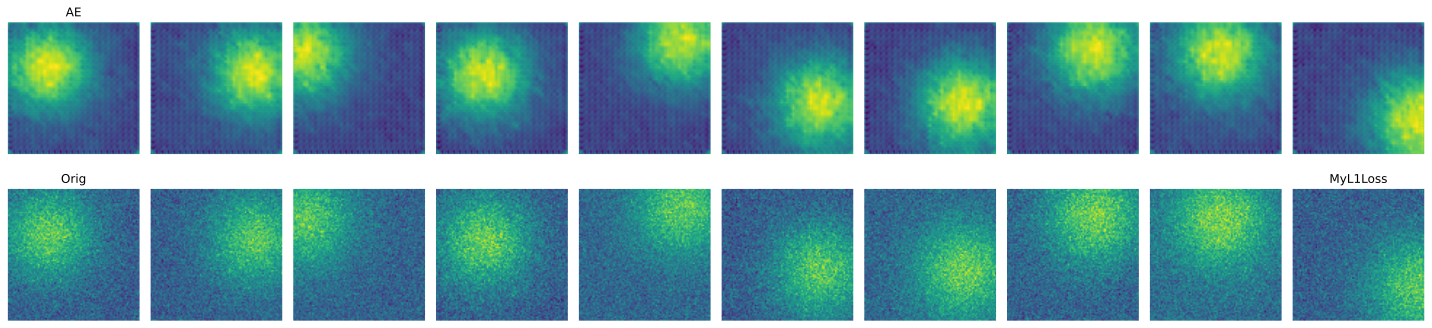

In [62]:
ae_images = models[0](images)
fig, ax = plt.subplots(2, 10, figsize=(20, 5))
for i in range(2):
    for j in range(10):
        if i%2:
            ax[i, j].imshow(torch.permute(images[j].detach(), [2, 1, 0]))
            ax[i, j].axis("off")
        else:
            ax[i, j].imshow(torch.permute(ae_images[j].detach(), [2, 1, 0]))
            ax[i, j].axis("off")
ax[0, 0].set_title("AE")
ax[1, 0].set_title("Orig")
plt.tight_layout()
plt.title("MyL1Loss")
plt.show()

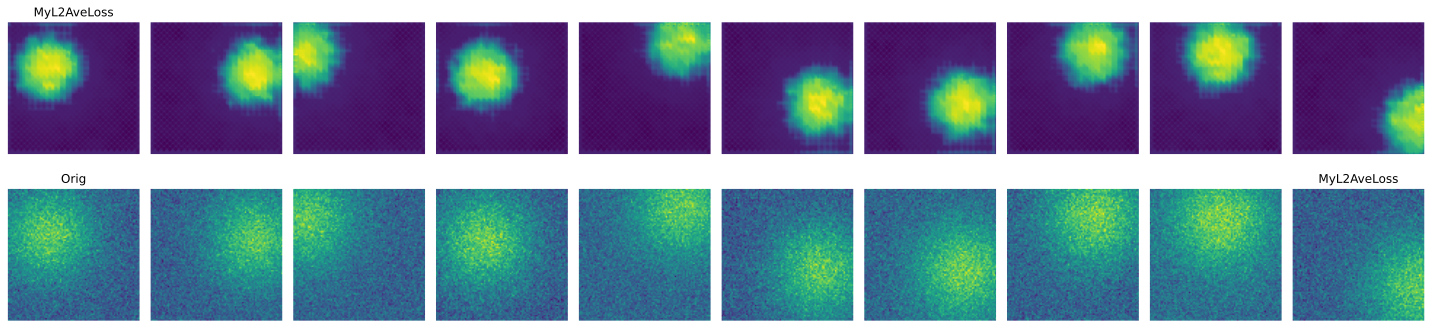

In [63]:
ae_images = models[1](images)
fig, ax = plt.subplots(2, 10, figsize=(20, 5))
for i in range(2):
    for j in range(10):
        if i%2:
            ax[i, j].imshow(torch.permute(images[j].detach(), [2, 1, 0]))
            ax[i, j].axis("off")
        else:
            ax[i, j].imshow(torch.permute(ae_images[j].detach(), [2, 1, 0]))
            ax[i, j].axis("off")
ax[0, 0].set_title("MyL2AveLoss")
ax[1, 0].set_title("Orig")
plt.tight_layout()
plt.title("MyL2AveLoss")
plt.show()

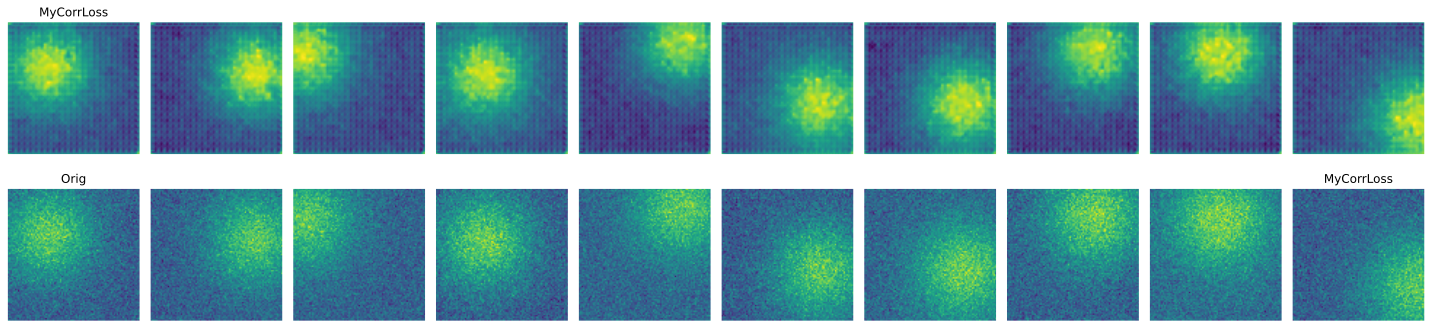

In [64]:
ae_images = models[2](images)
fig, ax = plt.subplots(2, 10, figsize=(20, 5))
for i in range(2):
    for j in range(10):
        if i%2:
            ax[i, j].imshow(torch.permute(images[j].detach(), [2, 1, 0]))
            ax[i, j].axis("off")
        else:
            ax[i, j].imshow(torch.permute(ae_images[j].detach(), [2, 1, 0]))
            ax[i, j].axis("off")
ax[0, 0].set_title("MyCorrLoss")
ax[1, 0].set_title("Orig")
plt.tight_layout()
plt.title("MyCorrLoss")
plt.show()